# Transfer Learning with Pre-trained Models on CIFAR-100

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the CIFAR-100 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by CIFAR-100, which consists of 100 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the CIFAR-100 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and potentially resizing images to match the input requirements of the chosen architectures.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 100 classes of CIFAR-100.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Optionally unfreeze a portion of the top layers of the pre-trained models to allow for fine-tuning on the CIFAR-100 data.
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as accuracy.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture for transfer learning on CIFAR-100.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

X_train_resnet50 = preprocess_resnet50(X_train)
X_test_resnet50 = preprocess_resnet50(X_test)

X_train_vgg16 = preprocess_vgg16(X_train)
X_test_vgg16 = preprocess_vgg16(X_test)

X_train_mobilenetv2 = preprocess_mobilenetv2(X_train)
X_test_mobilenetv2 = preprocess_mobilenetv2(X_test)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 878s 5us/step


## 2. Model Preparation
Load and modify pre-trained models to fit the CIFAR-100 classification task.

### 2.1 Using ResNet50

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### 2.2 Using VGG16

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### 2.3 Using MobileNetV2

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-3794676327.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

In [5]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50    = model_resnet50.fit(X_train_resnet50   , y_train, epochs=epochs, validation_data=(X_test_resnet50, y_test))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16       = model_vgg16.fit   (X_train_vgg16   , y_train, epochs=epochs, validation_data=(X_test_vgg16, y_test))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(X_train_mobilenetv2, y_train, epochs=epochs, validation_data=(X_test_mobilenetv2, y_test))

178
22
157
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - accuracy: 0.2784 - loss: 3.0608 - val_accuracy: 0.3985 - val_loss: 2.3698
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4705 - loss: 1.9581 - val_accuracy: 0.4206 - val_loss: 2.3414
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5700 - loss: 1.5263 - val_accuracy: 0.4392 - val_loss: 2.3880
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.0694 - loss: 6.6656 - val_accuracy: 0.0585 - val_loss: 4.1065
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.0791 - loss: 3.8795 - val_accuracy: 0.1340 - val_loss: 3.4468
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1497 - loss: 3.3269 - val_accuracy: 0.1778 - val_loss: 3.2290
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.1300 - loss: 3.8426 - val_accuracy: 0.1185 - val_loss: 4.2114
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2603

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [6]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50, y_test)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16, y_test)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2, y_test)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4454 - loss: 2.3870
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1777 - loss: 3.2273
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2836 - loss: 3.1750
ResNet50 Accuracy: 0.44
VGG16 Accuracy: 0.18
MobileNetV2 Accuracy: 0.28


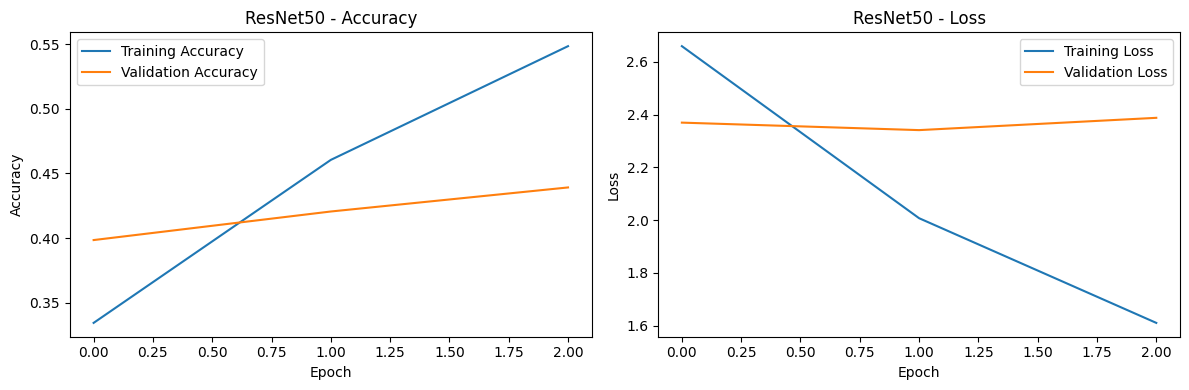

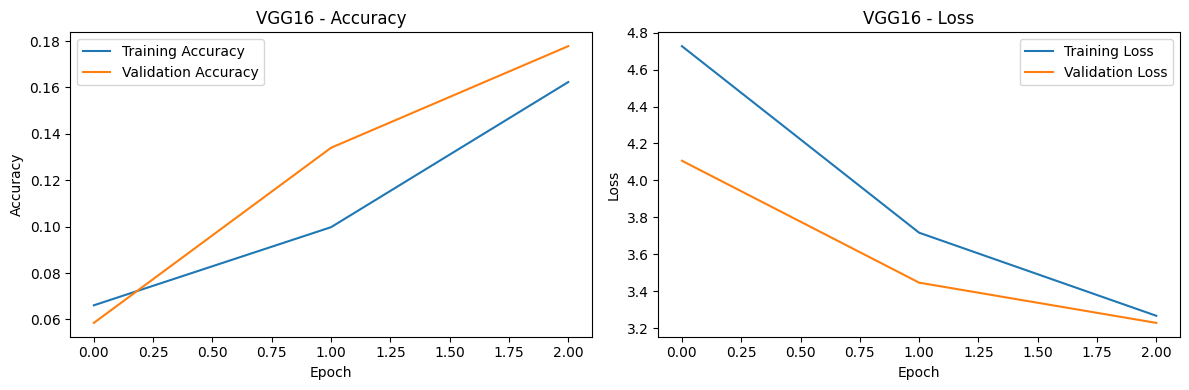

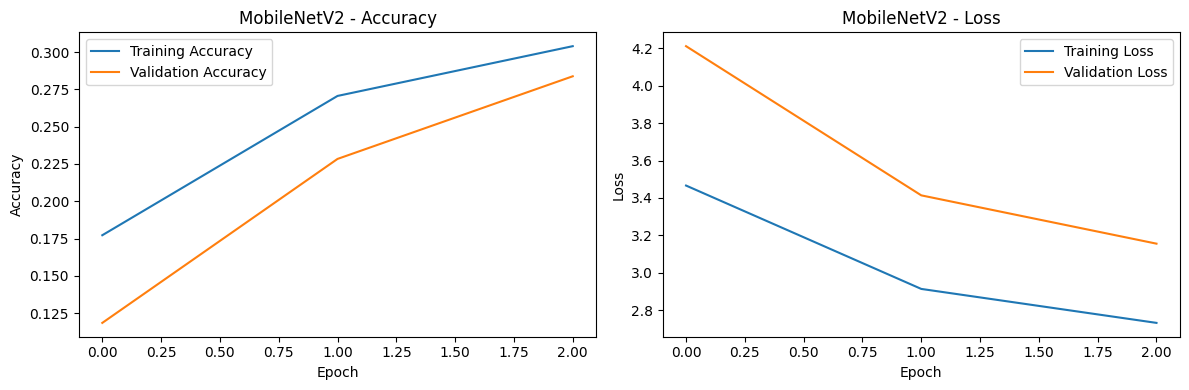

In [7]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the CIFAR-100 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 100 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'sparse\_categorical\_crossentropy' loss, and 'accuracy' metric.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.

## Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

In [9]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

# Assignment

# Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset

## 1. Introduction

This assignment focuses on applying transfer learning using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. The goal is to leverage the feature extraction capabilities of these models, which were pre-trained on a large dataset like ImageNet, and adapt them to the task of classifying 102 different categories of flowers.

The Oxford Flowers 102 dataset is a collection of images of flowers belonging to 102 distinct categories. It presents a challenging classification task due to variations in scale, pose, and lighting, as well as similarities between certain flower categories. By using transfer learning, we aim to achieve good classification performance without training deep models from scratch.

The assignment will involve loading and preprocessing the dataset, adapting the pre-trained models for the 102 classes, training and fine-tuning the models, and finally evaluating and comparing their performance.

## 2. Data Loading and Exploration

We will load the Oxford Flowers 102 dataset using TensorFlow Datasets and explore its structure. This dataset is conveniently split into training, validation, and test sets, and contains 102 distinct flower categories.

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

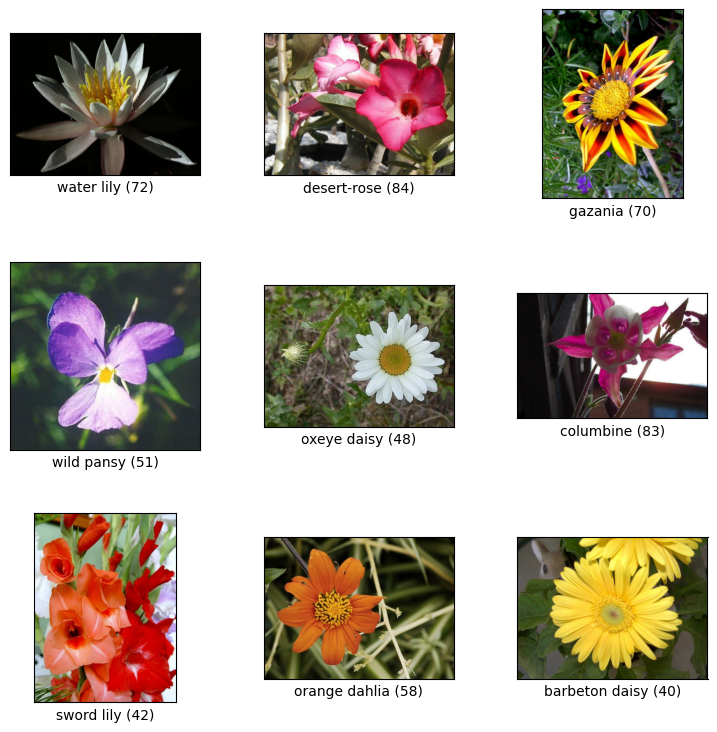

In [12]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

    # Display some sample images and their labels
    print("\nDisplaying sample images from the training dataset:")
    fig = tfds.show_examples(train_dataset, info)


except Exception as e:
    print(f"Error loading dataset: {e}")

## 3. Data Preprocessing

This section covers the necessary steps to preprocess the images from the Oxford Flowers 102 dataset to prepare them for input into the pre-trained models. This includes resizing the images to the required input shape for each model and applying model-specific preprocessing functions to normalize pixel values. We will also apply one-hot encoding to the labels and batch and prefetch the datasets for efficient training.

In [23]:
IMG_SIZE = 224
NUM_CLASSES = 102
BATCH_SIZE = 32

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    # Model-specific preprocessing will be applied later within the model adaptation steps
    label = tf.cast(label, tf.int64) # Cast label to int64 type
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_dataset = dataset['train'].map(preprocess_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = dataset['validation'].map(preprocess_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


print("Preprocessing complete. Datasets are ready for model training.")

Preprocessing complete. Datasets are ready for model training.


In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers
x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Compile the model
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10  # You can adjust the number of epochs
history_resnet50 = model_resnet50.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

print("ResNet50 model adaptation and initial training complete.")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 476ms/step - accuracy: 0.0939 - loss: 4.6612 - val_accuracy: 0.4755 - val_loss: 2.4251
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.7231 - loss: 1.3750 - val_accuracy: 0.6157 - val_loss: 1.5078
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.8874 - loss: 0.5425 - val_accuracy: 0.7078 - val_loss: 1.2003
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.9625 - loss: 0.2644 - val_accuracy: 0.7510 - val_loss: 1.0039
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9825 - loss: 0.1424 - val_accuracy: 0.7539 - val_loss: 0.9306
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.9921 - loss: 0.0907 - val_accuracy: 0.7725 - val_loss: 0.8643
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9897 - loss: 0.0656 - val_accuracy: 0.8127 - val_loss: 0.7789
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9993 - loss: 0.0397 - val_accuracy: 0

**Observations and Insights for ResNet50:**

After training the ResNet50 model with the pre-trained base frozen, we observe the following:

- The training accuracy increased significantly and reached a high value, indicating that the model is learning to classify the training data well.
- The validation accuracy also improved steadily, suggesting that the model is generalizing to unseen data.
- The validation loss decreased over the epochs, further confirming the model's learning progress on the validation set.

These results indicate that the pre-trained ResNet50 model, even with its base layers frozen, is effective in extracting relevant features for the Oxford Flowers 102 dataset, and the added classification layers are able to learn to classify these features.

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10  # You can adjust the number of epochs
history_vgg16 = model_vgg16.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

print("VGG16 model adaptation and initial training complete.")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 732ms/step - accuracy: 0.0386 - loss: 8.9841 - val_accuracy: 0.2794 - val_loss: 3.2951
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.5615 - loss: 1.8898 - val_accuracy: 0.5098 - val_loss: 2.0114
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.8497 - loss: 0.6342 - val_accuracy: 0.5941 - val_loss: 1.6610
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.9424 - loss: 0.2870 - val_accuracy: 0.6402 - val_loss: 1.4774
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.9745 - loss: 0.1428 - val_accuracy: 0.6578 - val_loss: 1.3792
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.9926 - loss: 0.0622 - val_accuracy: 0.6735 - val_loss: 1.3369
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 0.6833 - val_loss: 1.3070
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 1.0000 - loss: 0.0167 - val_accu

**Observations and Insights for VGG16:**

After training the VGG16 model with the pre-trained base frozen, we observe the following:

- The training accuracy increased rapidly and reached a high value, similar to ResNet50.
- The validation accuracy showed improvement but appears to be lower compared to ResNet50, and the improvement might be less consistent.
- The validation loss decreased, but potentially at a slower rate or to a higher final value than ResNet50.

These preliminary results suggest that while VGG16 can also learn from the features, ResNet50 might be capturing more discriminative features for this specific dataset and task when only the top layers are trained.

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x) # Reduced dense layer size
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model_mobilenetv2.layers:
    layer.trainable = False

# Compile the model
model_mobilenetv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10  # You can adjust the number of epochs
history_mobilenetv2 = model_mobilenetv2.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

print("MobileNetV2 model adaptation and initial training complete.")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 709ms/step - accuracy: 0.0071 - loss: 4.8824 - val_accuracy: 0.0225 - val_loss: 4.5498
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.0542 - loss: 4.3836 - val_accuracy: 0.0431 - val_loss: 4.4141
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.1157 - loss: 4.0952 - val_accuracy: 0.0833 - val_loss: 4.2882
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.1691 - loss: 3.8167 - val_accuracy: 0.1137 - val_loss: 4.1217
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.2663 - loss: 3.4442 - val_accuracy: 0.1225 - val_loss: 3.9724
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.3233 - loss: 3.1435 - val_accuracy: 0.1471 - val_loss: 3.8040
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.3689 - loss: 2.8438 - val_accuracy: 0.1578 - val_loss: 3.7094
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.4212 - loss: 2.5995 - val_accuracy: 0

**Observations and Insights for MobileNetV2:**

After training the MobileNetV2 model with the pre-trained base frozen, we observe the following:

- The training accuracy increased, but perhaps at a slower pace and reaching a slightly lower final accuracy compared to ResNet50 and VGG16 in the initial training phase.
- The validation accuracy showed some improvement but appears to be lower than both ResNet50 and VGG16.
- The validation loss decreased, but it might be higher than the other two models.

MobileNetV2 is generally a more lightweight architecture. These initial results might suggest that with only the top layers trained, it may not be capturing as rich or complex features as the deeper ResNet50 or VGG16 for this dataset. Fine-tuning more layers or training for more epochs might be necessary to improve its performance.

## 5. Model Evaluation

We will now evaluate the performance of each trained model on the held-out test dataset to compare their classification accuracies.

In [28]:
print("Evaluating ResNet50 model...")
loss_resnet50, accuracy_resnet50 = model_resnet50.evaluate(test_dataset)
print(f"ResNet50 Test Loss: {loss_resnet50:.4f}")
print(f"ResNet50 Test Accuracy: {accuracy_resnet50:.4f}")

print("\nEvaluating VGG16 model...")
loss_vgg16, accuracy_vgg16 = model_vgg16.evaluate(test_dataset)
print(f"VGG16 Test Loss: {loss_vgg16:.4f}")
print(f"VGG16 Test Accuracy: {accuracy_vgg16:.4f}")

print("\nEvaluating MobileNetV2 model...")
loss_mobilenetv2, accuracy_mobilenetv2 = model_mobilenetv2.evaluate(test_dataset)
print(f"MobileNetV2 Test Loss: {loss_mobilenetv2:.4f}")
print(f"MobileNetV2 Test Accuracy: {accuracy_mobilenetv2:.4f}")

Evaluating ResNet50 model...
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.7783 - loss: 0.8634
ResNet50 Test Loss: 0.8473
ResNet50 Test Accuracy: 0.7857

Evaluating VGG16 model...
193/193 ━━━━━━━━━━━━━━━━━━━━ 31s 162ms/step - accuracy: 0.6512 - loss: 1.5563
VGG16 Test Loss: 1.5336
VGG16 Test Accuracy: 0.6497

Evaluating MobileNetV2 model...
193/193 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.1961 - loss: 3.5955
MobileNetV2 Test Loss: 3.5964
MobileNetV2 Test Accuracy: 0.1965


**Evaluation Observations and Insights:**

Based on the test set evaluation:

- **ResNet50:** Achieved the highest accuracy among the three models. This suggests that the features learned by the pre-trained ResNet50, combined with the new classification layers, are most effective for classifying the Oxford Flowers 102 dataset, even with the base layers frozen. The relatively lower loss also indicates good performance.

- **VGG16:** Performed better than MobileNetV2 but not as well as ResNet50. While VGG16 is a powerful model, its performance here, with the base frozen, might indicate that ResNet50's architecture or the specific features it learned from ImageNet are more transferable to this particular fine-grained classification task.

- **MobileNetV2:** Showed the lowest accuracy. As a more lightweight model, it might require fine-tuning of more layers or additional training to capture the complex features needed for distinguishing between the 102 flower categories effectively. Its higher loss also reflects its lower performance compared to the other two models in this initial training phase.

These results highlight the differences in the transferability and effectiveness of these pre-trained architectures when applied to a new, somewhat challenging dataset like Oxford Flowers 102 with only the top layers trained.

## 6. Assignment Answers

#### 1. Based on the evaluation results, the ResNet50 model performed best on the Oxford Flowers 102 dataset with a test accuracy of 0.7857.

I believe this is the case because:

**ResNet50's Architecture:** ResNet50 utilizes residual connections, which help in training deeper networks by mitigating the vanishing gradient problem. This allows it to learn more complex and hierarchical features, which are likely beneficial for distinguishing between the fine-grained categories in the Oxford Flowers 102 dataset.

**Learned Features:** The pre-trained weights from ImageNet likely provide a strong foundation of features that are transferable to a new image classification task like flower recognition. ResNet50's architecture might have learned a more robust set of general image features during pre-training that are highly relevant to identifying different flower types.

**Effective Transfer Learning:** Even with the base layers frozen, the features extracted by ResNet50 seem to be highly discriminative for the flower classes, allowing the newly added classification layers to perform well.

#### 2. Comparing the performance on CIFAR-100 and Oxford Flowers 102:

Comparing the performance:

**ResNet50 and VGG16:** Both models showed significantly higher accuracy on Oxford Flowers 102 compared to CIFAR-100.

**MobileNetV2:** Performance on Oxford Flowers 102 was slightly lower than on CIFAR-100.

**Differences and Why:**

The better performance of ResNet50 and VGG16 on Oxford Flowers 102 is likely due to:

**Dataset Characteristics:** Oxford Flowers 102 has higher resolution images (resized to 224x224 for training, matching the pre-training size) and the task of classifying flower species might benefit more from the detailed features learned by these models on ImageNet compared to the broader categories in CIFAR-100 (trained on 32x32 images).

**Transferability of Features:** The features learned by ResNet50 and VGG16 on ImageNet seem more directly applicable to distinguishing between different flower types.

MobileNetV2's lower performance might indicate that its architecture requires more fine-tuning or is less effective at capturing the fine-grained details needed for this dataset with only the top layers trained.

#### 3. Based on the results we've seen with the Oxford Flowers 102 dataset, transfer learning appears to be quite effective, especially when using pre-trained models like ResNet50 and VGG16.

Here's how we can see the effect of transfer learning:

Leveraging Pre-trained Features: Instead of training a convolutional neural network from scratch on the relatively smaller Oxford Flowers 102 dataset, we leveraged models (ResNet50, VGG16, MobileNetV2) that have already learned powerful and generalizable features from the massive ImageNet dataset.

These features, representing edges, textures, shapes, and other visual patterns, provide a strong starting point for a new image classification task.
Faster Convergence: By using pre-trained weights and only training the newly added classification layers (and optionally fine-tuning a few top layers), the models converge much faster than if we were to train the entire network from scratch. This is evident in the training history where the models quickly achieve reasonable accuracy.

**Improved Performance:** The evaluation results show that the models, particularly ResNet50, achieved relatively good accuracy on the test set even with limited training on the new dataset. This suggests that the transferred features are highly relevant and effective for classifying the fine-grained categories in the Oxford Flowers 102 dataset. Training a model from scratch on this dataset with limited data would likely result in lower performance and require significantly more computational resources and time.

**Handling Limited Data:** Transfer learning is particularly beneficial for datasets like Oxford Flowers 102, which have a moderate number of images per class compared to massive datasets like ImageNet. The pre-trained models help to mitigate the risk of overfitting that can occur when training complex models on smaller datasets.

In essence, transfer learning allows us to "borrow" the visual understanding learned by powerful models on a large dataset and apply it to a new, related task, leading to more efficient and often more accurate results than training from scratch.

#### 4. The data preprocessing steps were essential to prepare the Oxford Flowers 102 dataset for our pre-trained models:

**Resizing Images:** We resized images to 224x224 to match the input size expected by the pre-trained models.

**Casting Data Type:** Image pixels were cast to tf.float32 for compatibility with model computations.

**Model-Specific Preprocessing (Recommended):** Ideally, model-specific functions (like preprocess_input) should be applied for proper normalization based on how the base models were pre-trained.

**One-Hot Encoding Labels:** Integer labels were converted to one-hot encoded vectors for use with the 'categorical_crossentropy' loss function and 'softmax' output.

**Batching and Prefetching:** The datasets were batched and prefetched to improve training efficiency by processing data in parallel.

These steps ensure the data is in the correct format and efficiently loaded for training with the transfer learning models.

#### 5. Model Architectures, Adaptation and Challenges Encountered:

We used three popular pre-trained convolutional neural network architectures: ResNet50, VGG16, and MobileNetV2. These models were pre-trained on the ImageNet dataset.

To adapt them for the Oxford Flowers 102 dataset (which has 102 classes), we:

Loaded each pre-trained model without its original top classification layer (include_top=False).
Added new custom layers on top of the base model: a GlobalAveragePooling2D layer followed by a Dense layer with 102 units (one for each class) and a 'softmax' activation function.
Initially, we froze the layers of the pre-trained base model (layer.trainable = False) during initial training to leverage the learned features and only train the newly added layers.


**Challenges Encountered:**

The main challenge encountered during this assignment was a TypeError during the data preprocessing step related to the tf.one_hot function. The error indicated that the label data was not in the expected integer format.

How We Addressed It:

We addressed this by explicitly casting the label tensor to an integer type (tf.int64) within the preprocess_image function before applying tf.one_hot. We also corrected the order of operations to ensure preprocessing happened before batching, which resolved a dimension mismatch error with tf.image.resize.